In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

In [2]:
data = pd.read_csv('Reviews.csv')

In [3]:
data.rename(columns={'UserId': 'user_id', 'ProductId': 'product_id', 'Score': 'rating'}, inplace=True)

In [4]:
data.head()

,Id,product_id,user_id,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,rating,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Check dataset structure and missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   product_id              568454 non-null  object
 2   user_id                 568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   rating                  568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
data.isnull().sum()

Id                         0
product_id                 0
user_id                    0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
rating                     0
Time                       0
Summary                   27
Text                       0
dtype: int64

# Basic stats of numerical columns

In [7]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,rating,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
data['user_id'].nunique()

256059

In [9]:
data['product_id'].nunique()

74258

# Rating Distribution

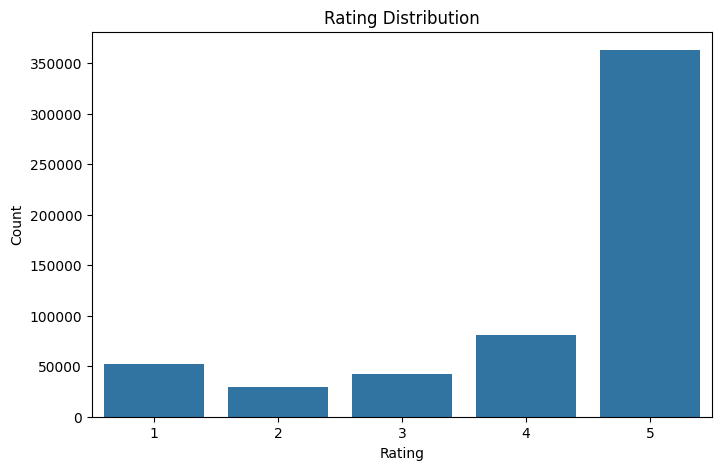

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=data)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Check for Duplicates

In [11]:
duplicates = data.duplicated().sum()
duplicates

0

# Drop rows with missing values

In [12]:
data = data.dropna()

# Save cleaned data

In [13]:
data.to_csv('cleaned_amazon_reviews.csv', index=False)

In [14]:
reader = Reader(rating_scale=(1, 5))

In [15]:
surprise_data = Dataset.load_from_df(data[['user_id', 'product_id', 'rating']], reader)

In [16]:
algo = SVD()

In [23]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
trainset = surprise_data.build_full_trainset()
algo.fit(trainset)

In [24]:
user_id = str(data.iloc[0]['user_id'])
product_id = str(data.iloc[0]['product_id'])
prediction = algo.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} on product {product_id}: {prediction.est}")

Predicted rating for user A3SGXH7AUHU8GW on product B001E4KFG0: 4.384571474399214


In [25]:
import pickle
with open('svd_recommendation_model.pkl', 'wb') as model_file:
    pickle.dump(algo, model_file)

print("Model saved successfully.")


Model saved successfully.


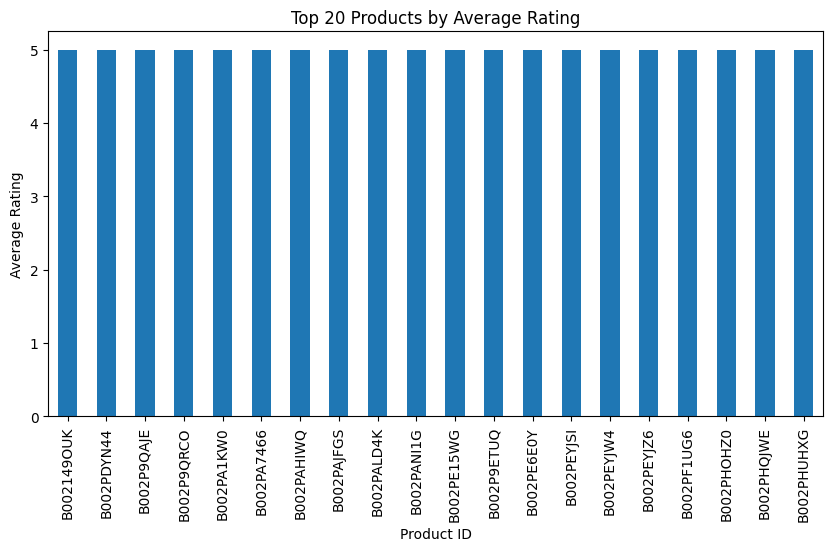

In [26]:
# Ratings per Product
plt.figure(figsize=(10, 5))
product_ratings = data.groupby('product_id')['rating'].mean().sort_values(ascending=False).head(20)
product_ratings.plot(kind='bar')
plt.title('Top 20 Products by Average Rating')
plt.xlabel('Product ID')
plt.ylabel('Average Rating')
plt.show()

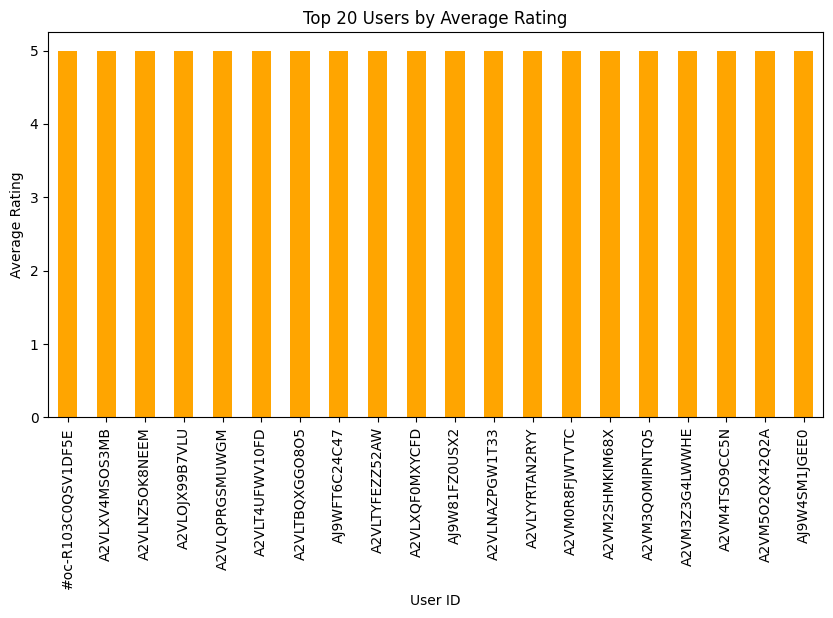

In [27]:
# Ratings per User
plt.figure(figsize=(10, 5))
user_ratings = data.groupby('user_id')['rating'].mean().sort_values(ascending=False).head(20)
user_ratings.plot(kind='bar', color='orange')
plt.title('Top 20 Users by Average Rating')
plt.xlabel('User ID')
plt.ylabel('Average Rating')
plt.show()


In [18]:
# ✅ Ensure that `trainset` is properly built
trainset = surprise_data.build_full_trainset()
algo.fit(trainset)

# 🎯 Function to Recommend Products for a Given User
def recommend_products(user_id, algo, trainset, data, num_recommendations=5):
    # Convert user_id to internal format
    try:
        inner_uid = trainset.to_inner_uid(user_id)
    except ValueError:
        print(f"User {user_id} not found in training data.")
        return None

    # Get all product IDs
    all_products = data['product_id'].unique()
    
    # Get products that the user has already rated
    rated_products = data[data['user_id'] == user_id]['product_id'].unique()
    
    # Filter out products the user has already rated
    products_to_predict = list(set(all_products) - set(rated_products))
    
    # Predict ratings for all unseen products
    predictions = [algo.predict(user_id, product).est for product in products_to_predict]
    
    # Create a DataFrame with predicted ratings
    recommendations = pd.DataFrame({'product_id': products_to_predict, 'predicted_rating': predictions})
    
    # Sort by highest predicted rating
    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    
    return recommendations

# 🔍 Example: Recommend Top 5 Products for a Specific User
sample_user = str(data['user_id'].iloc[0])  # Replace with any valid user_id
recommended_products = recommend_products(sample_user, algo, trainset, data)
print(f"\nTop Recommended Products for User {sample_user}:\n")
print(recommended_products)



Top Recommended Products for User A3SGXH7AUHU8GW:

       product_id  predicted_rating
7745   B000O5DI1E               5.0
18596  B000FK63LK               5.0
7477   B000LKXJW0               5.0
25086  B0012KH0H8               5.0
40488  B002U4OV6I               5.0


In [ ]:
A1D87F6ZCVE5NK

In [19]:
sample_user = str('A1D87F6ZCVE5NK')  # Replace with any valid user_id
recommended_products = recommend_products(sample_user, algo, trainset, data)
print(f"\nTop Recommended Products for User {sample_user}:\n")
print(recommended_products)


Top Recommended Products for User A1D87F6ZCVE5NK:

       product_id  predicted_rating
62385  B000Q0IMOK          4.801063
55214  B000EMAZS6          4.795972
19746  B0002PHEZC          4.775227
4068   B005A1LG7K          4.722396
48733  B001IZ9ME6          4.721882
